#### Importing

In [1]:
# importing data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.feature_selection import mutual_info_classif

# importing classifiers 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

import re
### importing utils
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import log_loss,f1_score,accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
%matplotlib inline

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [2]:
def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
#!pip install -U dataprep

In [4]:
X_full = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [5]:
def process(df):
    
    #remove non-numerical characters from office 
    df.OFFICE = df.OFFICE.str.replace(r"[a-zA-Z]",'')
    df.OFFICE = df.OFFICE.astype(int)
    
    #remove non-numerical characters from origin 
    df["ORIGIN.CODE"] = df["ORIGIN.CODE"].str.replace(r"[a-zA-Z]",'')
    df["ORIGIN.CODE"] = df["ORIGIN.CODE"].astype(int)    
    #fill missing date values with a random date
    df['date'] = pd.to_datetime(df['date'])
    #split date 
    
    df["year"] = df['date'].dt.year
    df["month"] = df['date'].dt.month
    df["day"] = df['date'].dt.day
    
    df['woy'] = df['date'].dt.weekofyear
    df['dow'] = df['date'].dt.dayofweek
    df['woy'] = df['woy'].fillna(34)
    df['day'] = df['day'].fillna(23)
    
    df['year'] = df['year'].fillna(2014)
    
    df['woy'] = df['woy'].fillna(34)
    
    #drop date
    df = df.drop(["date"],axis=1)
    df = df.drop(["ID"],axis=1)
    
    #split importer words from num
    L_type=[]
    L_imp=[]
    for index, row in df.iterrows():
        a=re.split('(\d+)',df['IMPORTER.TIN'][index])
        L_type.append(a[0])
        L_imp.append(a[1])
    df['IMPORTER_Type']=L_type
    df['IMPORTER']=L_imp
    df['IMPORTER'] = df['IMPORTER'].astype(int)
    df = df.drop(["IMPORTER.TIN"],axis=1)
    outliers = []
    
    df['IMPORTER_Type'].replace({'IMP':0, 'IMPO':1},inplace=True)

    df.loc[:, 'Q'] = df.loc[:,'TOTAL.TAXES.USD'] / df.loc[:,'GROSS.WEIGHT']
    df.loc[:, 'WQ'] = df.loc[:,'GROSS.WEIGHT'] / df.loc[:,'QUANTITY']
  
    
    
   
    
    
    

    
  
    """df['chapter'] = df['TARIFF.CODE'].astype(str).str[0:2]
    df['heading'] = df['TARIFF.CODE'].astype(str).str[2:4]
    df['sub-heading'] = df['TARIFF.CODE'].astype(str).str[4:6]
    df['extra_digits'] = df['TARIFF.CODE'].astype(str).str[6:]
    df.drop(columns=['TARIFF.CODE'],inplace=True)"""
    
    
    return df

In [6]:
X_full = process(X_full)

In [7]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   OFFICE              160000 non-null  int32  
 1   TARIFF.CODE         160000 non-null  int64  
 2   ORIGIN.CODE         160000 non-null  int32  
 3   CIF_USD_EQUIVALENT  160000 non-null  float64
 4   QUANTITY            160000 non-null  float64
 5   GROSS.WEIGHT        160000 non-null  float64
 6   TOTAL.TAXES.USD     160000 non-null  float64
 7   illicit             160000 non-null  int64  
 8   year                160000 non-null  float64
 9   month               157244 non-null  float64
 10  day                 160000 non-null  float64
 11  woy                 160000 non-null  float64
 12  dow                 157244 non-null  float64
 13  IMPORTER_Type       160000 non-null  int64  
 14  IMPORTER            160000 non-null  int32  
 15  Q                   160000 non-nul

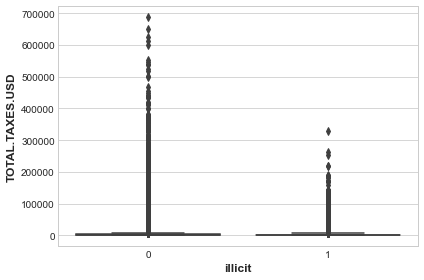

In [8]:
ax=sns.boxplot(x= "illicit", y=X_full['TOTAL.TAXES.USD'], data = X_full)

In [9]:

X = X_full.drop('illicit',axis=1)
y = X_full.illicit

X_train, X_valid, y_train, y_valid =train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

#### Modeling 

In [10]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

In [11]:
params = {
    'learning_rate':0.15,  

    'subsample':0.9,
 
      
}

In [12]:
xgb_model = XGBClassifier(learning_rate=params['learning_rate'],scale_pos_weight=10)
xgb_model.fit(X_train, y_train)

# Making predictions
y_pred = xgb_model.predict(X_valid)

[06:36:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
def evaluate(test,predictions):
    print(f'Accuracy score: {accuracy_score(test, predictions)}')
    print('\n')
    print(f'{classification_report(test, predictions)}')

In [14]:
evaluate(y_valid,y_pred)

Accuracy score: 0.81509375


              precision    recall  f1-score   support

           0       0.98      0.82      0.89     29803
           1       0.23      0.75      0.36      2197

    accuracy                           0.82     32000
   macro avg       0.61      0.78      0.62     32000
weighted avg       0.93      0.82      0.86     32000



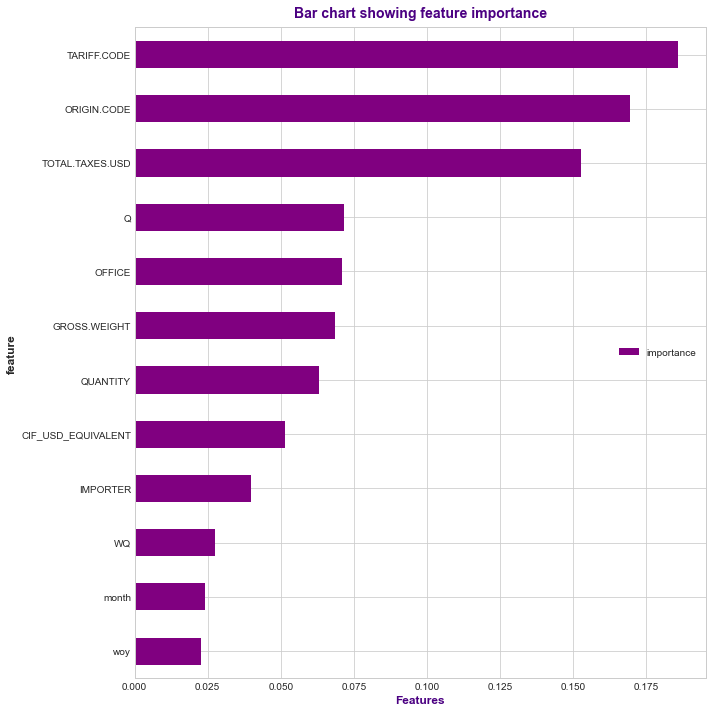

In [15]:
impo_df = pd.DataFrame({'feature': X_train.columns, 'importance': xgb_model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [16]:
ss = pd.read_csv('sample_submission.csv')
df_test = pd.read_csv('test.csv')
test = process(df_test)
ss['illicit'] = xgb_model.predict(test)
version = 'I.csv'
ss.to_csv(version, index=False)